In [1]:
import IPython
import pandas as pd
import numpy as np
from statistics import mode
import statsmodels.api as sm
import matplotlib.pyplot as plt  


In [2]:
# load modified file with some pre-processing completed
df = pd.read_csv("diabetes_data_preprocessed.csv", index_col=0)
df.shape

(95672, 83)

### Data Visualization

v:\d drive\program files\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of Readmission')

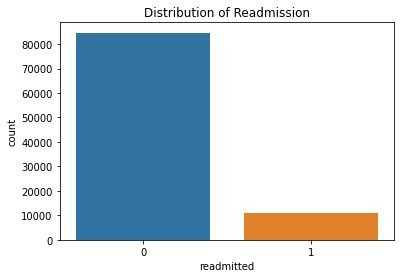

In [34]:
sns.countplot(df['readmitted']).set_title('Distribution of Readmission')

#### Time in hospital and readmission

Text(0.5, 1.0, 'Time in Hospital VS. Readmission')

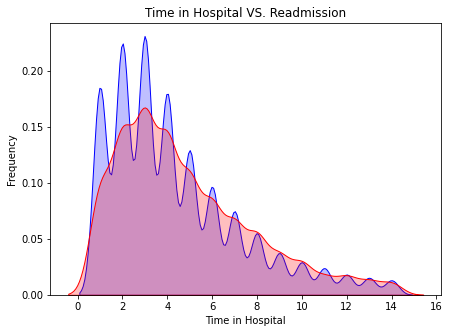

In [42]:
fig = plt.figure(figsize=(7,5),)
ax=sns.kdeplot(df.loc[(df['readmitted'] == 0),'time_in_hospital'] , color='b',shade=True,label='Not Readmitted')
ax=sns.kdeplot(df.loc[(df['readmitted'] == 1),'time_in_hospital'] , color='r',shade=True, label='Readmitted')
ax.set(xlabel='Time in Hospital', ylabel='Frequency')
plt.title('Time in Hospital VS. Readmission')

#### Age and Readmission

Text(0.5, 1.0, 'Age of Patient VS. Readmission')

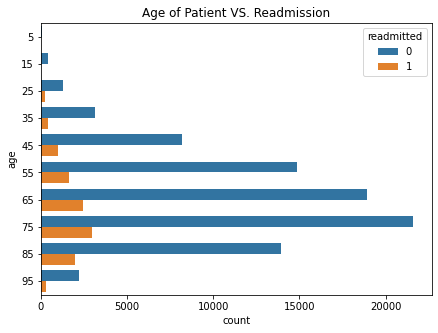

In [41]:
fig = plt.figure(figsize=(7,5))
sns.countplot(y= df['age'], hue = df['readmitted']).set_title('Age of Patient VS. Readmission')

#### Number of medication used and Readmission

Text(0.5, 1.0, 'Number of medication used VS. Readmission')

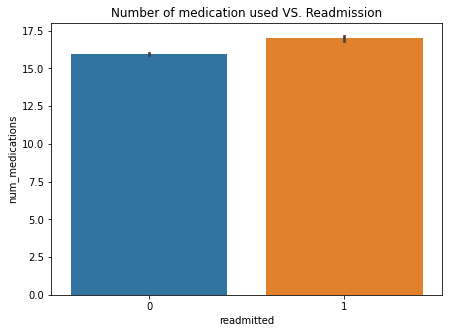

In [47]:
fig = plt.figure(figsize=(7,5))
sns.barplot(x = df['readmitted'], y = df['num_medications']).set_title("Number of medication used VS. Readmission")

Text(0.5, 1.0, 'Number of lab procedure VS. Readmission')

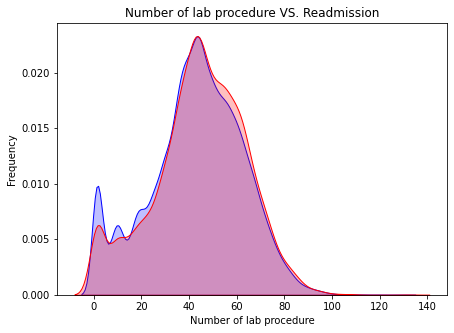

In [46]:
fig = plt.figure(figsize=(7,5),)
ax=sns.kdeplot(df.loc[(df['readmitted'] == 0),'num_lab_procedures'] , color='b',shade=True,label='Not readmitted')
ax=sns.kdeplot(df.loc[(df['readmitted'] == 1),'num_lab_procedures'] , color='r',shade=True, label='readmitted')
ax.set(xlabel='Number of lab procedure', ylabel='Frequency')
plt.title('Number of lab procedure VS. Readmission')

#### Remove the duplicated record with the same patient number, keep the first record to narrow the scope

In [3]:
df = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
df.shape

(67128, 83)

### Remove outliers

In [4]:
from scipy import stats
numerical_columns = ['time_in_hospital', 'num_lab_procedures', 
                     'num_procedures', 'num_medications','number_outpatient',
                     'number_emergency','number_inpatient','number_diagnoses']

df_noOutlier = df[(np.abs(stats.zscore(df[numerical_columns])) < 3).all(axis=1)]
df_noOutlier.shape

(62414, 83)

### Normalization between 0 and 1

In [5]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = preprocessing.MinMaxScaler()
df_minmax = min_max_scaler.fit_transform(df_noOutlier)
df_minmax = pd.DataFrame(df_minmax, columns = df_noOutlier.columns)

In [6]:
X = df_minmax.drop(['readmitted'], axis=1)
y = df_minmax['readmitted']

## Logistic Regression

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
logit = LogisticRegression(fit_intercept=True, penalty='l2')
logit.fit(X_train, y_train)

v:\d drive\program files\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [19]:
logit_pred = logit.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(logit_pred, name = 'Predict'), margins = True)

Predict,0.0,All
Actual,,
0.0,2209,2209
1.0,261,261
All,2470,2470


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, logit_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, logit_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, logit_pred)))
print("AUC score is {0:.2f}".format(roc_auc_score(y_test, logit_pred)))

Accuracy is 0.91
Precision is 0.00
Recall is 0.00
AUC score is 0.50


v:\d drive\program files\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### The target variable is imbalance. Number of  readmitted patient are very small as compared to Not readmitted

v:\d drive\program files\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distrinution of Readmission')

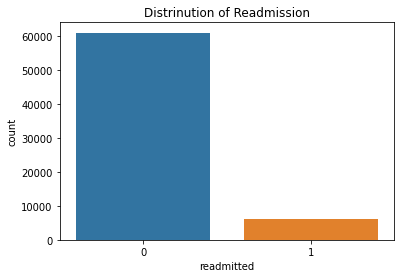

In [10]:
import seaborn as sns
sns.countplot(df['readmitted']).set_title('Distribution of Readmission')

## Now we need to apply SMOTE teachnique to balance the two classes

In [67]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print('Dataset shape before SMOTE{}'.format(Counter(y_train)))
sm = SMOTE(random_state=20)
train_input_new, train_output_new = sm.fit_sample(X_train, y_train)
print('Dataset shape after SMOTE {}'.format(Counter(train_output_new)))

Dataset shape before SMOTECounter({0.0: 45583, 1.0: 4348})
Dataset shape after SMOTE Counter({0.0: 45583, 1.0: 45583})


### After SMOTE

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

train_input_new = pd.DataFrame(train_input_new, columns = list(X.columns))
X_train, X_test, y_train, y_test = train_test_split(train_input_new, train_output_new, test_size=0.20, random_state=0)
logit = LogisticRegression(fit_intercept=True, penalty='l2')
logit.fit(X_train, y_train)

v:\d drive\program files\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [69]:
logit_pred = logit.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(logit_pred, name = 'Predict'), margins = True)

Predict,0.0,1.0,All
Actual,,,
0.0,1666,1615,3281
1.0,153,154,307
All,1819,1769,3588


In [70]:
accuracy_logit = accuracy_score(y_test, logit_pred)
precision_logit = precision_score(y_test, logit_pred)
recall_logit = recall_score(y_test, logit_pred)
auc_logit = roc_auc_score(y_test, logit_pred)

print("Accuracy is {0:.2f}".format(accuracy_logit))
print("Precision is {0:.2f}".format(precision_logit))
print("Recall is {0:.2f}".format(recall_logit))
print("AUC score is {0:.2f}".format(auc_logit))

Accuracy is 0.61
Precision is 0.62
Recall is 0.60
AUC score is 0.61


### Para tuning

In [11]:
# C_param_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# X_train, X_test, y_train, y_test = train_test_split(train_input_new, train_output_new, test_size=0.20, random_state=0)
# for i in C_param_range:  
#     logit = LogisticRegression(fit_intercept=True, penalty='l2', C=i, random_state = 42)
#     logit.fit(X_train, y_train)
#     logit_pred = logit.predict(X_test)
#     accuracy_logit = accuracy_score(y_test, logit_pred)
#     print("Learning rate: ", i," Accuracy is {0:.3f}".format(accuracy_logit))

### Random Forest

In [71]:
# Data balancing applied using SMOTE
train_input_new, train_output_new = sm.fit_sample(X, y)
print('New dataset shape {}'.format(Counter(train_output_new)))
train_input_new = pd.DataFrame(train_input_new, columns = list(X.columns))
X_train, X_test, Y_train, Y_test = train_test_split(train_input_new, train_output_new, test_size=0.20, random_state=42)

New dataset shape Counter({0.0: 56951, 1.0: 56951})


In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forrest = RandomForestClassifier(n_estimators = 30, max_depth=30, criterion = "gini", min_samples_split=10)
print("Cross Validation score: {:.2%}".format(np.mean(cross_val_score(forrest, X_train, Y_train, cv=10))))
forrest.fit(X_train, Y_train)
print("Dev Set score: {:.2%}".format(forrest.score(X_test, Y_test)))

Cross Validation score: 94.90%
Dev Set score: 94.97%


In [73]:
Y_test_predict = forrest.predict(X_test)
pd.crosstab(pd.Series(Y_test, name = 'Actual'), pd.Series(Y_test, name = 'Predict'), margins = True)

Predict,0.0,1.0,All
Actual,,,
0.0,11552,0,11552
1.0,0,11229,11229
All,11552,11229,22781


In [74]:
accuracy_forreste = accuracy_score(Y_test, Y_test_predict)
precision_forreste = precision_score(Y_test, Y_test_predict)
recall_forreste = recall_score(Y_test, Y_test_predict)
auc_forreste = roc_auc_score(Y_test, Y_test_predict)

print("Accuracy is {0:.2f}".format(accuracy_forreste))
print("Precision is {0:.2f}".format(precision_forreste))
print("Recall is {0:.2f}".format(recall_forreste))
print("AUC score is {0:.2f}".format(auc_forreste))

Accuracy is 0.95
Precision is 1.00
Recall is 0.90
AUC score is 0.95


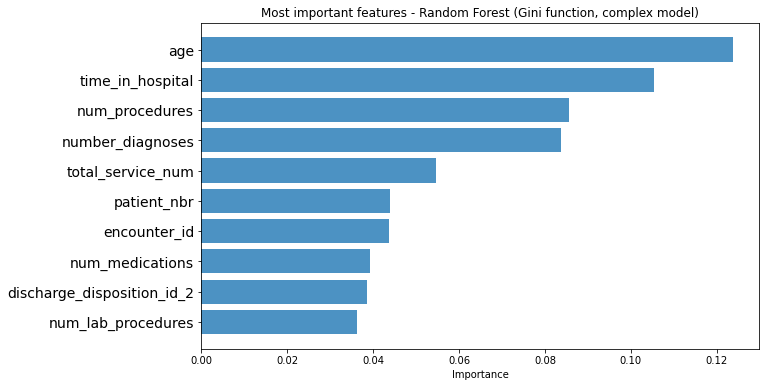

In [75]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = forrest.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest (Gini function, complex model)')
plt.show()

In [34]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score
# max_depth_range = [5, 10, 20, 30]
# for i in n_estimators_range:
#     forrest = RandomForestClassifier(n_estimators = 100, max_depth=i, criterion = "gini", min_samples_split=10)
#     forrest.fit(X_train, Y_train)
#     Y_test_predict = forrest.predict(X_test)
#     accuracy_forreste = accuracy_score(Y_test, Y_test_predict)
#     print("Accuracy is {0:.3f}".format(accuracy_forreste))

Accuracy is 0.952


## Decision Tree

In [76]:
# Continue to use SMOTE
train_input_new, train_output_new = sm.fit_sample(X, y)
print('New dataset shape {}'.format(Counter(train_output_new)))
train_input_new = pd.DataFrame(train_input_new, columns = list(X.columns))
X_train, X_test, y_train, y_test = train_test_split(train_input_new, train_output_new, test_size=0.20, random_state=42)

New dataset shape Counter({0.0: 56951, 1.0: 56951})


In [77]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=30, criterion = "entropy", min_samples_split=30)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=30, min_samples_split=30)

In [78]:
dtree_pred = dtree.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(dtree_pred, name = 'Predict'), margins = True)

Predict,0.0,1.0,All
Actual,,,
0.0,2201,1954,4155
1.0,247,201,448
All,2448,2155,4603


In [79]:
accuracy_dtree = accuracy_score(y_test, dtree_pred)
precision_dtree = precision_score(y_test, dtree_pred)
recall_dtree = recall_score(y_test, dtree_pred)
auc_dtree = roc_auc_score(Y_test, dtree_pred)

print("Accuracy is {0:.2f}".format(accuracy_dtree))
print("Precision is {0:.2f}".format(precision_dtree))
print("Recall is {0:.2f}".format(recall_dtree))
print("AUC score is {0:.2f}".format(auc_dtree))

Accuracy is 0.92
Precision is 0.94
Recall is 0.89
AUC score is 0.92


                       Feature  Importance
5               num_procedures    0.012210
6              num_medications    0.014553
4           num_lab_procedures    0.019188
41  discharge_disposition_id_2    0.022764
32           total_service_num    0.023032
0                 encounter_id    0.024973
1                  patient_nbr    0.025841
10            number_diagnoses    0.027202
2                          age    0.067344
3             time_in_hospital    0.662365


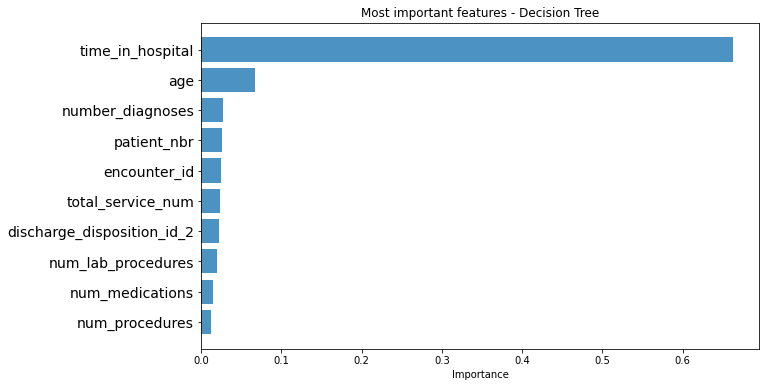

In [80]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = dtree.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Decision Tree')
plt.show()

In [47]:
# from sklearn.tree import DecisionTreeClassifier
# depth_range = [5, 10, 20, 30]
# for i in depth_range:
#     dtree = DecisionTreeClassifier(max_depth=50, criterion = "entropy", min_samples_split=30)
#     dtree.fit(X_train, y_train)
#     dtree_pred = dtree.predict(X_test)
#     accuracy_dtree = accuracy_score(y_test, dtree_pred)
#     print("Accuracy is {0:.3f}".format(accuracy_dtree))

Accuracy is 0.916
Accuracy is 0.916
Accuracy is 0.916
Accuracy is 0.916


## Gradient Boosting

In [49]:
# Data balancing applied using SMOTE
train_input_new, train_output_new = sm.fit_sample(X, y)
print('New dataset shape {}'.format(Counter(train_output_new)))
train_input_new = pd.DataFrame(train_input_new, columns = list(X.columns))
X_train, X_test, Y_train, Y_test = train_test_split(train_input_new, train_output_new, test_size=0.20, random_state=42)

New dataset shape Counter({0.0: 56951, 1.0: 56951})


#### Testing learning rate

In [51]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.75, max_features=10, max_depth=10, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, Y_train)))
    print("Accuracy score (testing): {0:.3f}".format(gb_clf.score(X_test, Y_test)))

Learning rate:  0.05
Accuracy score (training): 0.910
Accuracy score (testing): 0.900
Learning rate:  0.075
Accuracy score (training): 0.920
Accuracy score (testing): 0.910
Learning rate:  0.1
Accuracy score (training): 0.931
Accuracy score (testing): 0.922
Learning rate:  0.25
Accuracy score (training): 0.948
Accuracy score (testing): 0.936
Learning rate:  0.5
Accuracy score (training): 0.961
Accuracy score (testing): 0.940
Learning rate:  0.75
Accuracy score (training): 0.966
Accuracy score (testing): 0.936
Learning rate:  1
Accuracy score (training): 0.967
Accuracy score (testing): 0.927


#### Observe that learning_rate=0.75 gives the highest accuracy

In [64]:
gb_clf2 = GradientBoostingClassifier(n_estimators=30, learning_rate=0.75, max_features=10, max_depth=20, random_state=0)
gb_clf2.fit(X_train, Y_train)
Y_test_predict = gb_clf2.predict(X_test)

In [65]:
accuracy_gBoost = accuracy_score(Y_test, Y_test_predict)
precision_gBoost = precision_score(Y_test, Y_test_predict)
recall_gBoost = recall_score(Y_test, Y_test_predict)
auc_gBoost = roc_auc_score(Y_test, Y_test_predict)

print("Accuracy is {0:.2f}".format(accuracy_gBoost))
print("Precision is {0:.2f}".format(precision_gBoost))
print("Recall is {0:.2f}".format(recall_gBoost))
print("AUC score is {0:.2f}".format(auc_gBoost))

Accuracy is 0.96
Precision is 0.99
Recall is 0.91
AUC score is 0.95


In [63]:
# depth_range = [5, 10, 20, 30]
# for i in depth_range:
#     gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.75, max_features=30, max_depth=i, random_state=0)
#     gb_clf.fit(X_train, y_train)
#     Y_test_predict = gb_clf.predict(X_test)
#     accuracy_gBoost = accuracy_score(Y_test, Y_test_predict)
#     print("Accuracy is {0:.3f}".format(accuracy_gBoost))

Accuracy is 0.941
Accuracy is 0.935
Accuracy is 0.950
Accuracy is 0.951


### Models Comparision

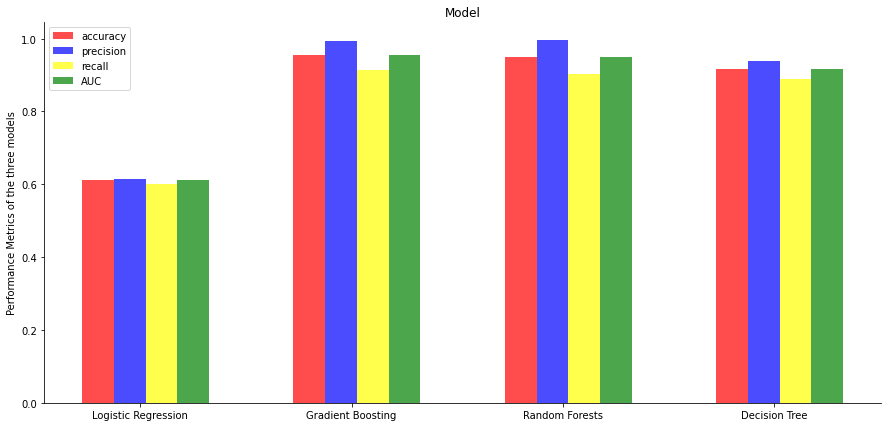

In [81]:
plt.figure(figsize=(15, 7))
ax = plt.subplot(111)

models = ['Logistic Regression', 'Gradient Boosting', 'Random Forests', 'Decision Tree']
model = np.arange(len(models))
plt.xticks([0.2, 1.2, 2.2, 3.2], models)   

values = [accuracy_logit, accuracy_gBoost, accuracy_forreste, accuracy_dtree]
plt.bar(model, values, align='center', width = 0.15, alpha=0.7, color = 'red', label= 'accuracy')
  
values = [precision_logit, precision_gBoost, precision_forreste, precision_dtree]
plt.bar(model+0.15, values, align='center', width = 0.15, alpha=0.7, color = 'blue', label = 'precision')

values = [recall_logit, recall_gBoost, recall_forreste, recall_dtree]
plt.bar(model+0.3, values, align='center', width = 0.15, alpha=0.7, color = 'yellow', label = 'recall')

values = [auc_logit, auc_gBoost, auc_forreste, auc_dtree]
plt.bar(model+0.45, values, align='center', width = 0.15, alpha=0.7, color = 'green', label = 'AUC')

plt.ylabel('Performance Metrics of the three models')
plt.title('Model')
    
# removing the axis on the top and right of the plot window
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

plt.show()  